In [1]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import itertools
import re
%matplotlib inline

In [2]:
#Leemos y guardamos dos csv secundarios
steam_requirement = pd.read_csv("Data/steam_requirements_data.csv")
steamspy_tag = pd.read_csv("Data/steamspy_tag_data.csv")

In [3]:
#Limpiamos los datos de la tabla para procesarlos más tarde, para ello creamos funciones (En el codigo sucio se hizo por separado)
def calcular_criticas(row):
    #Calculamos las criticas positivas y negativas y su porcentag
    import math
    pos = row["positive_ratings"]
    neg = row["negative_ratings"]
    total = pos + neg
    avg = pos / total
    criticas = avg - (avg*0.5)*2**(-math.log10(total+1))
    return criticas * 100
def separacion(serie):
    #Funcion para separar el contenido de las columnas separadas por ;
    return set(list(itertools.chain(*serie.apply(lambda x: [c for c in x.split(";")]))))
def categorias(df):
    #Separamos las categorias y los generos. Aqui me interesa si es o no Multiplayer y los generos que se pueden buscar en steam
    #Aqui buscamos los multyplayers
    cat = separacion(df["categories"])
    cat = ["Multi-player","Single-player"]
    for col in sorted(cat):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
    #Aqui buscamos los generos
    gen = separacion(df["genres"])
    gen = ["Action", "Adventure", "Casual", "Indie", "Massive Multiplayer", "RPG", "Racing", "Simulation", "Sports", "Strategy"]
    gen_name = []
    for col in sorted(gen):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_name.append(col_name)
        df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    gen_sums = df[gen_name].sum(axis=1)
    df = df[gen_sums > 0].copy()
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    return df
def procesado():
    #Leemos el CSV
    df = pd.read_csv("Data/steam.csv")
    #Convertimos la columna owners en un solo número
    df["owners"] = df["owners"].str.split("-").apply(lambda x: x[0]).astype(int)
    #Calculamos las criticas
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calcular_criticas, axis=1)
    #Separamos tambien las categorias
    df["categories"] = df["categories"].apply(lambda x: x.split(";")).astype(str)
    #Convertimos las fechas en datetimes
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    df = categorias(df)
    df['type'] = 'Free'
    df.loc[df['price'] > 0, 'type'] = 'Paid'
    return df
original = pd.read_csv("Data/steam.csv")   
steam = procesado()
steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,genres,achievements,...,adventure,casual,indie,massive_multiplayer,rpg,racing,simulation,sports,strategy,type
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,0,Paid
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,0,Paid
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,0,Paid
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,0,Paid
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,0,Paid


In [4]:
#Cuantos juegos sacan por año en steam
fig = go.Figure()
fig.add_trace(go.Bar(x = steam["release_date"].dt.year.value_counts().index[:12],
                     y  = steam["release_date"].dt.year.value_counts().values[:12],
                     marker_color = "DarkOrchid" ))
fig.update_layout(
    height=600, width=800, title_text="Juegos por año", title_x = 0.5, paper_bgcolor = "black", font=dict(
            size=14,
            color="white")
)
fig.show()

<Figure size 720x432 with 0 Axes>

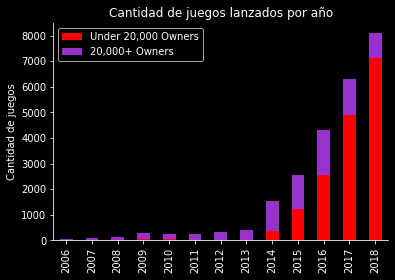

In [5]:
#Los juegos lanzados en steam cada año viendo cuales tienen más de 20k de usuarios
plt.figure(figsize=(10,6))
df = steam.copy()
years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    year_df = df[df.release_year == year]
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
with plt.style.context('dark_background'): 
    
    owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                            columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])
    
    ax = owners_df.plot(
        x="year",
        y=[1,2],
        kind="bar",
        stacked=True,
        color=["red", "DarkOrchid"]
    )
    ax.set_xlabel("")
    ax.set_ylabel("Cantidad de juegos")
    ax.set_title("Cantidad de juegos lanzados por año")
    
    sns.despine()
plt.show()

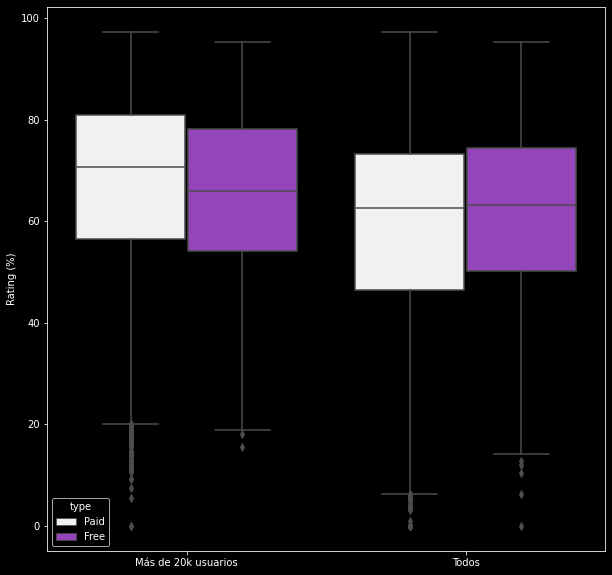

In [6]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10,6))
    fig.set_figheight(10)
    fig.set_figwidth(10)
    dfb = steam.copy()
    dfa = steam[steam.owners >= 20000].copy()
    dfa['subset'] = "Más de 20k usuarios"

    dfb = steam.copy()
    dfb['subset'] = "Todos"
    ax = sns.boxplot(
        x='subset',
        y="rating",
        hue="type",
        color="DarkOrchid",
        data=pd.concat([dfa,dfb]))
    ax.set(xlabel='', ylabel='Rating (%)')
plt.show()

c:\Users\Bustos_Traceur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



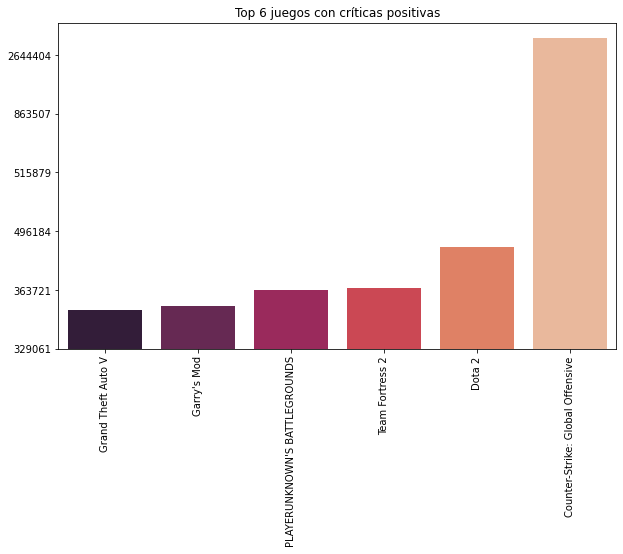

In [7]:
#Los 6 juegos con mas criticas positivas
positivas =  steam[["name", "positive_ratings"]]
positive = positivas.sort_values(by="positive_ratings", ascending=False)[:6]
positive = positive.sort_values("positive_ratings")
positive
fig,ax = plt.subplots(figsize=(10,6))
sns.set_palette("rocket")
sns.barplot(
    x=positive["name"],
    y=positive["positive_ratings"],
    palette="rocket"
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
plt.title("Top 6 juegos con críticas positivas")
ax.set_yticklabels(positive['positive_ratings']);

c:\Users\Bustos_Traceur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



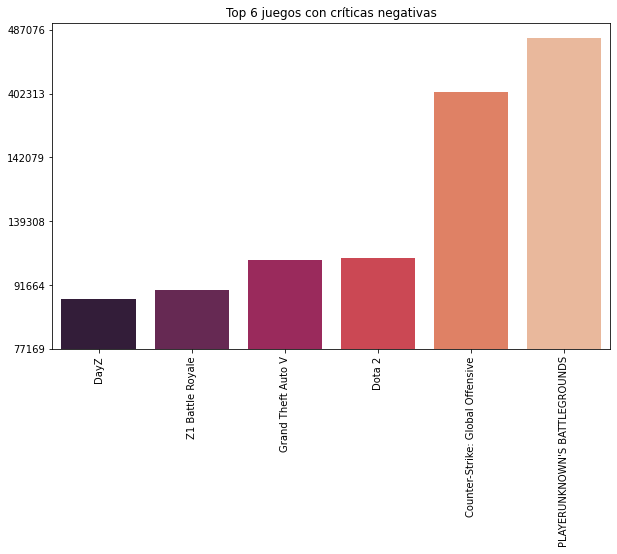

In [8]:
#Sacamos ahora las negativas
negativas =  steam[["name", "negative_ratings"]]
negative = negativas.sort_values(by="negative_ratings", ascending=False)[:6]
negative = negative.sort_values("negative_ratings")
negative
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(
    x=negative["name"],
    y=negative["negative_ratings"],
    palette = "rocket"
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
plt.title("Top 6 juegos con críticas negativas")
ax.set_yticklabels(negative["negative_ratings"]);

In [9]:
#A partir del csv original sacaremos los generos mas frecuentes
#Limpiamos la columna tags

original["categories"] = original["categories"].apply(lambda x: x.split(";"))


In [10]:
#vamos sacar todas las categorias existentes
def get_labels(data):
  unique_labels = []
  all_labels = []
  for i in range(len(data)):
    for label in data[i]:
      all_labels.append(label)
      if label not in unique_labels:
        unique_labels.append(label)
  return unique_labels, all_labels

In [11]:
unique_cats, all_cats = get_labels(original["categories"])

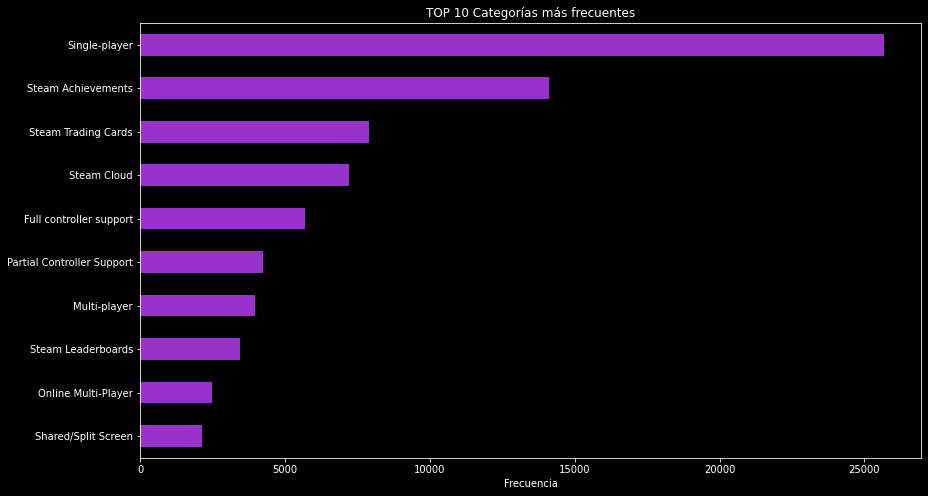

In [12]:
#Hacemos una comparativa de los TOP10 categorias
with plt.style.context('dark_background'):
    plt.figure(figsize=(14,8))
    pd.Series(all_cats).value_counts()[:10].plot(kind="barh", color="DarkOrchid")
    plt.gca().invert_yaxis()
    plt.xlabel("Frecuencia")
    plt.title("TOP 10 Categorías más frecuentes")
plt.show()


In [13]:
#Hacemos una comparativa de los TOP10 tipos
original["steamspy_tags"] = original["steamspy_tags"].apply(lambda x: x.split(";"))

In [14]:
#Separamos los tags
unique_tags, all_tags = get_labels(original["steamspy_tags"])
unique_tags[:10]

['Action',
 'FPS',
 'Multiplayer',
 'World War II',
 'Sci-fi',
 'Classic',
 'Singleplayer',
 'Puzzle',
 'First-Person',
 'Free to Play']

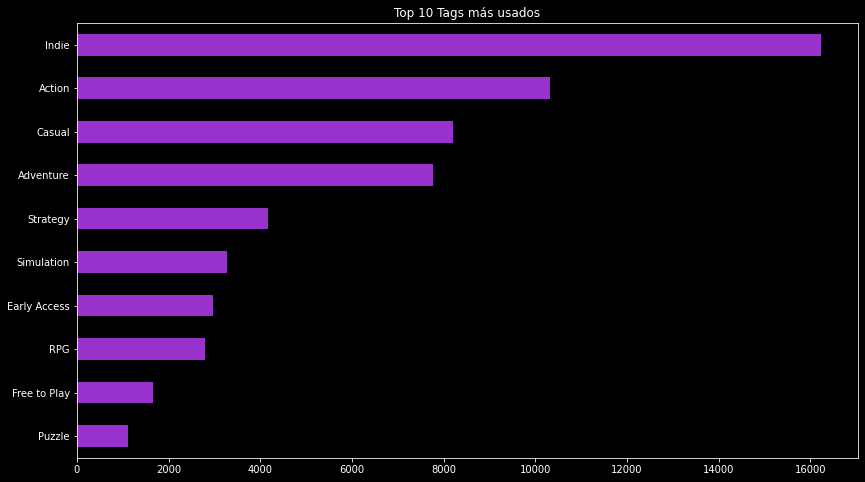

In [15]:
#Top 10 tags mas usados en steam

with plt.style.context('dark_background'):
    plt.figure(figsize = (14, 8))
    pd.Series(all_tags).value_counts().head(10).plot(kind = 'barh', color="DarkOrchid")
    plt.gca().invert_yaxis()
    plt.xlabel("")
    plt.title("Top 10 Tags más usados")
plt.show()

In [16]:
#veamos la cantidad de juegos gratiutos en steam
gratis, no_es_gratis = original[original["price"] == 0].shape[0], original[original["price"] != 0].shape[0]
labels = ["Gratuito", "De pago"]
fig = go.Figure(data=[go.Bar(x=labels, y=[gratis, no_es_gratis], marker_color="DarkOrchid")])
fig.update_layout(
    height=600, width=400, title_text="Frecuencia De Juegos Gratis y De Pago",
    title_x = 0.5,
    font=dict(
            size=14,
            color="white"),
    paper_bgcolor = "black"
)

fig.show()


In [17]:
#Juegos con un coste inferior a 10 euros
costo10, costo100 = original[original["price"] <= 10].shape[0], original[original["price"] > 10].shape[0]
labels = ["10€ o menos", "Más de 10€"]
fig = go.Figure(data=[go.Bar(x=labels, y=[costo10, costo100], marker_color="DarkOrchid")])
fig.update_layout(
    height=600, width=400, title_text="Juegos con un coste menor a 10€",
    title_x = 0.5,
    font=dict(
            size=14,
            color="white"),
    paper_bgcolor = "black"
)

fig.show()

In [18]:
#Aqui vemos que algo no cuadra, no se pueden tener tantas horas jugadas
media = steam[["name", "average_playtime"]]
media_horas = media.sort_values(by="average_playtime", ascending=False)[:5]
media_horas
fig = go.Figure()
fig.add_trace(go.Bar(x = media_horas["name"],
                     y  = media_horas["average_playtime"],
                     marker_color = "DarkOrchid",
                      ))
fig.update_layout(
    height=600, width=800, title_text="Top 5 juegos con mayor promedio de horas jugadas", title_x = 0.5,paper_bgcolor = "black", font=dict(
            size=14,
            color="white")
)
fig.show()

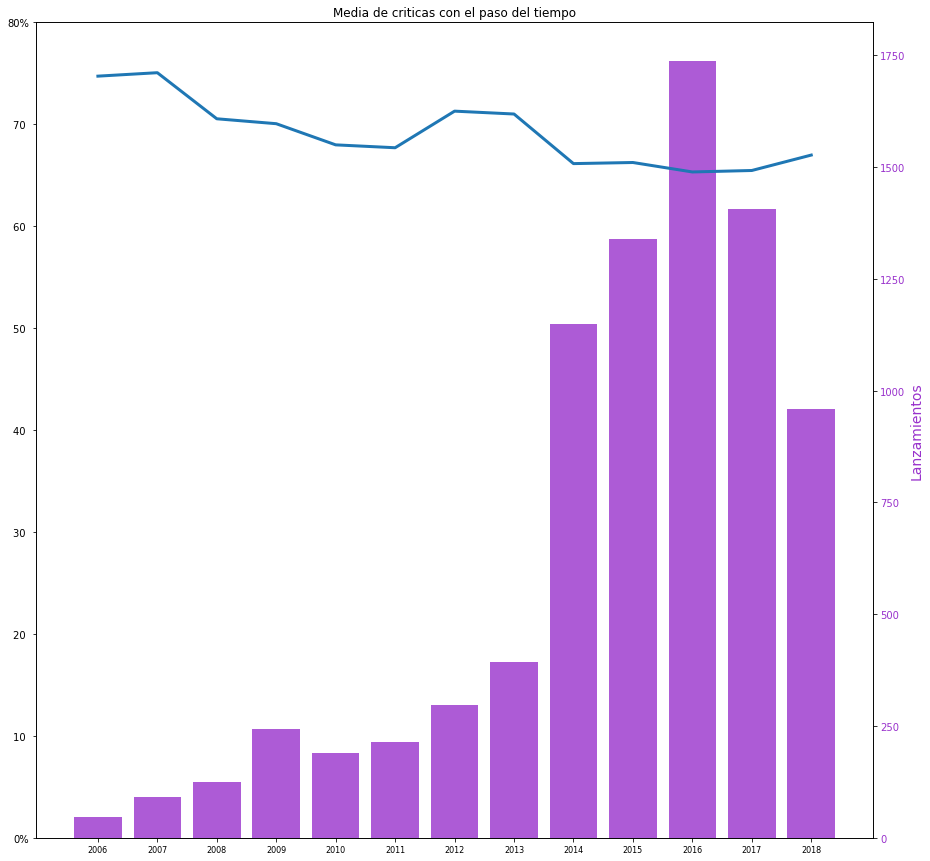

In [19]:
#Sacamos la media de criticas por cada año que pasa, con los juegos que tengas más de 20k de usuarios
df = steam[steam.owners >= 20000].copy()
years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []
#calcular las criticas
for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    avg_rating = year_data['rating'].mean() / 100
    years.append(year)
    totals.append(total)
    avg_ratings.append(avg_rating) 

#figura 
fig, ax1 = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
#vicualizar las dos
ax1.set_zorder(1)
ax1.patch.set_visible(False)

#trendlines
ax1.plot(avg_ratings, color='tab:blue', linewidth=3)
x_pos = np.arange(len(years))

#ticks
ax1.set_xticks(x_pos)
ax1.set_xticklabels(years, fontsize=8)
ax1.set_yticks(np.arange(0, 0.9, 0.1))
ax1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])
color = 'DarkOrchid'
ax2 = ax1.twinx()
color = 'DarkOrchid'
ax2.bar(x_pos, totals, color = 'DarkOrchid', alpha=.8)

ax2.set_ylabel('Lanzamientos', color="DarkOrchid", fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Media de criticas con el paso del tiempo')
plt.show()

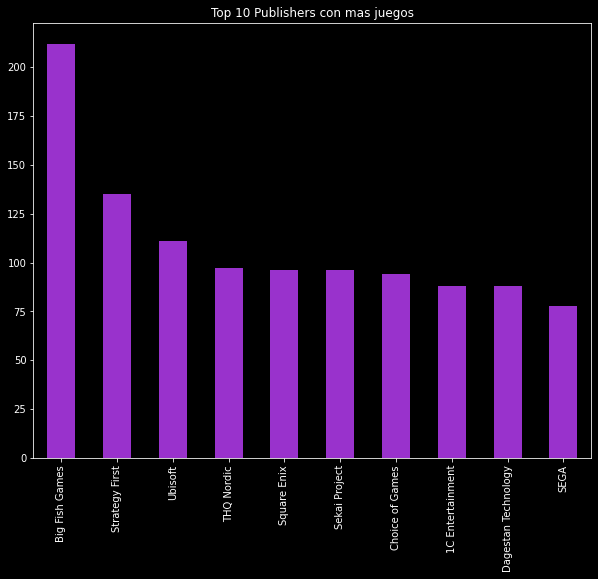

In [20]:
#Ahora sacamos los publishers de steam con mas juegos

with plt.style.context('dark_background'):
    plt.figure(figsize = (10, 8))
    steam['publisher'].value_counts().sort_values(ascending=False).head(10).plot(kind="bar", color="DarkOrchid")
    plt.xlabel("")
    plt.title("Top 10 Publishers con mas juegos")
plt.show()

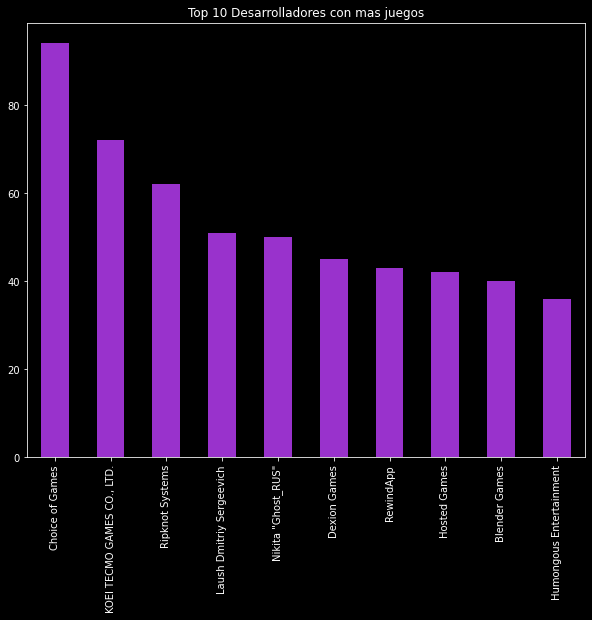

In [21]:
#Ahora sacamos los desarrolladores de steam con mas juegos

with plt.style.context('dark_background'):
    plt.figure(figsize = (10, 8))
    steam['developer'].value_counts().sort_values(ascending=False).head(10).plot(kind="bar", color="DarkOrchid")
    plt.xlabel("")
    plt.title("Top 10 Desarrolladores con mas juegos")
plt.show()

In [22]:
import scipy.stats as stats
display_cols = ['name', 'developer', 'publisher', 'release_year', 'genres', 'average_playtime', 'owners', 'rating', 'price']
cat_gen_cols = steam.columns[-13:-1]

In [23]:
gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])


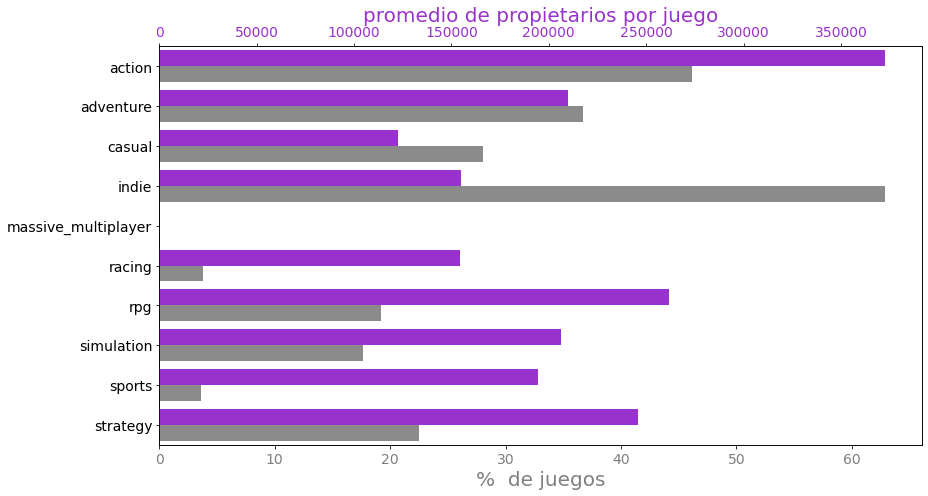

In [24]:
def plot_owners_comparison(steam):
    #Porcentage de juegos por tipo
    total_owners_per_genre = steam[gen_cols].multiply(steam['owners'], axis='index').sum()
    average_owners_per_genre = total_owners_per_genre / df[gen_cols].sum()

    fig, ax1 = plt.subplots(figsize=(13,7))

    color = 'tab:gray'
    (df[gen_cols].mean() * 100).sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.9, position=1, fontsize=14, width=0.4)


    ax1.set_xlabel("%  de juegos", color=color, size=20)
    ax1.tick_params(axis="x", labelcolor=color)
    ax1.tick_params(axis="y", left='off', top='off')

    ax2 = ax1.twiny()

    color = 'DarkOrchid'
    average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=1, position=0, fontsize=14, width=0.4)
    ax2.set_xlabel("promedio de propietarios por juego", color=color, size=20)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_ylim([-.5, 9.5])

    plt.tight_layout()
    plt.show()
    
plot_owners_comparison(df)

In [25]:
#top juegos y sus media de horas jugadas
media2 = steam[["name", "average_playtime", "owners"]]
media_horas2 = media2.sort_values(by="owners", ascending=False)[:5]
media_horas2
fig = go.Figure()
fig.add_trace(go.Bar(x = media_horas2["name"],
                     y  = media_horas2["average_playtime"],
                     marker_color = "DarkOrchid",
                      ))
fig.update_layout(
    height=600, width=800, title_text="Top 5 juegos con mayor promedio de horas jugadas", title_x = 0.5,paper_bgcolor = "black", font=dict(
            size=14,
            color="white")
)
fig.show()